In [91]:
import random
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from scipy import stats
from statsmodels.tsa.stattools import adfuller

from utils import (
    logging,
    TARGET_PROTEIN,
    SAMPLE_END_DATE,
    MUTATION_PER_SEQ_FILE,
    FIXATION_LINKAGE_FILE,
    RECOMMENDED_MUTATIONS_FILE
)

from utils.miscellaneous import remove_same_site_combo

combo_min_num = 2
score_threshold = 0


In [2]:
logging.info("Load data...")

df: pd.DataFrame = pd.read_feather(MUTATION_PER_SEQ_FILE)
df["Date"] = pd.to_datetime(df["Date"])

df = df[df["Mutation"].str.contains(TARGET_PROTEIN)]
df = df[~df["Mutation"].str.contains("stop")]
df = df[~df["Mutation"].str.contains("ins")]
df["AA"] = df["Mutation"].str.split("_").str[1].str[1:]

future_df = df[df["Date"] >= SAMPLE_END_DATE]
df = df[df["Date"] < SAMPLE_END_DATE]

fixation_linkage = pd.read_csv(FIXATION_LINKAGE_FILE)
aa_combo: pd.DataFrame = pd.read_feather(RECOMMENDED_MUTATIONS_FILE)
aa_combo = aa_combo[aa_combo["Accession"].str.contains(TARGET_PROTEIN)]


In [3]:
known_muts = set(df["AA"].unique())
all_possible_mut_combo = set(
    (frozenset(i) for i in combinations(known_muts, combo_min_num))
)
all_possible_mut_combo = remove_same_site_combo(all_possible_mut_combo)

len(all_possible_mut_combo)


4447099

In [4]:
existing_combo = []

ac_group: pd.DataFrame
for ac, ac_group in df.groupby("Accession", sort=False):
    if len(ac_group.index) >= combo_min_num:
        existing_combo.extend(
            (frozenset(i)
             for i in combinations(ac_group["AA"].values, combo_min_num))
        )

existing_combo = set(existing_combo)
assert len(existing_combo.difference(all_possible_mut_combo)) == 0

len(existing_combo)


13978

In [5]:
recommended_combo = []

mut_group: pd.DataFrame
for mut, mut_group in aa_combo.groupby("Accession", sort=False):
    mut = mut.split("_")[1][1:]
    mut_group = mut_group[mut_group["Score"] > score_threshold]
    mutated = (mut_group["Pos"].astype(str) + mut_group["AA"]).values
    recommended_combo.extend(
        (frozenset((mut, i)) for i in mutated if i != mut)
    )

recommended_combo = set(recommended_combo).difference(existing_combo)
len(recommended_combo)


3179832

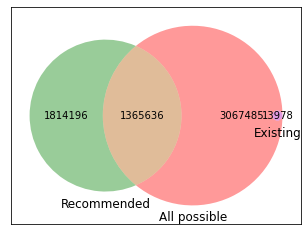

In [82]:
venn3(
    [all_possible_mut_combo, recommended_combo, existing_combo],
    ("All possible", "Recommended", "Existing")
)
plt.gca().set_facecolor('white')
plt.gca().set_axis_on()
plt.savefig("plots/venn_graph.pdf", bbox_inches="tight")


In [7]:
unreached_combo = all_possible_mut_combo.difference(existing_combo)
possible_combo = recommended_combo.intersection(all_possible_mut_combo)
random_combo = set(random.sample(
    list(unreached_combo),
    k=len(possible_combo)
))


In [39]:
future_combo = []
future_combo_stat = []
existing_future_combo = set()
ac_group: pd.DataFrame
c_date_group: pd.DataFrame
for c_date, c_date_group in future_df.groupby("Date", sort=False):
    c_date_combo = []
    c_date_group = c_date_group[c_date_group["AA"] != ""]
    for ac, ac_group in c_date_group.groupby("Accession", sort=False):
        if len(ac_group.index) >= combo_min_num:
            c_date_combo.extend(
                (frozenset(i)
                 for i in combinations(ac_group["AA"].values, combo_min_num))
            )

    c_date_combo = remove_same_site_combo(c_date_combo)
    c_date_combo = c_date_combo.difference(existing_combo)
    c_date_combo = c_date_combo.difference(existing_future_combo)

    hit_combo = c_date_combo.intersection(unreached_combo)
    hit_combo_recom = c_date_combo.intersection(possible_combo)
    hit_combo_random = c_date_combo.intersection(random_combo)
    future_combo_stat.append({
        "Date": c_date,
        "Target": len(c_date_combo),
        "Hit": len(hit_combo),
        "Hit_recom": len(hit_combo_recom),
        "Hit_random": len(hit_combo_random)
    })
    future_combo.extend(c_date_combo)
    existing_future_combo = existing_future_combo.union(c_date_combo)

future_combo_stat = pd.DataFrame(future_combo_stat)


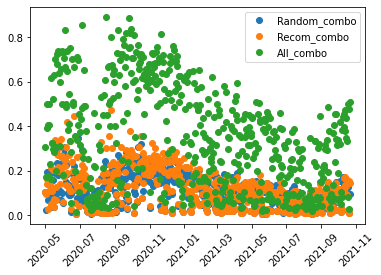

In [46]:
future_combo_stat_dated = future_combo_stat[future_combo_stat["Hit"] > 10].set_index("Date")

plt.plot_date(
    future_combo_stat_dated.index,
    future_combo_stat_dated["Hit_random"] / future_combo_stat_dated["Target"],
    label="Random_combo"
)
plt.plot_date(
    future_combo_stat_dated.index,
    future_combo_stat_dated["Hit_recom"] / future_combo_stat_dated["Target"],
    label="Recom_combo"
)
plt.plot_date(
    future_combo_stat_dated.index,
    future_combo_stat_dated["Hit"] / future_combo_stat_dated["Target"],
    label="All_combo"
)
plt.xticks(rotation=45)
plt.legend()


In [79]:
ma_days = 30

future_combo_stat_dated["Hit_avg"] = future_combo_stat_dated["Hit"].rolling(ma_days).mean()
future_combo_stat_dated["Hit_recom_avg"] = future_combo_stat_dated["Hit_recom"].rolling(ma_days).mean()
future_combo_stat_dated["Hit_random_avg"] = future_combo_stat_dated["Hit_random"].rolling(ma_days).mean()
future_combo_stat_ma = future_combo_stat_dated.dropna()

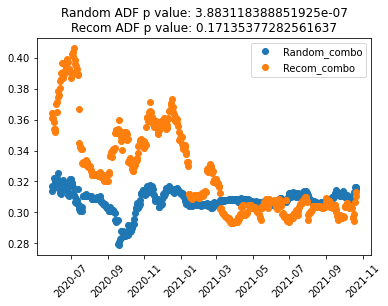

In [109]:
recom_p = adfuller(future_combo_stat_ma["Hit_recom"] / future_combo_stat_ma["Hit"])[1]
random_p = adfuller(future_combo_stat_ma["Hit_random"] / future_combo_stat_ma["Hit"])[1]

plt.plot_date(
    future_combo_stat_ma.index,
    future_combo_stat_ma["Hit_random_avg"] / future_combo_stat_ma["Hit_avg"],
    label="Random_combo"
)
plt.plot_date(
    future_combo_stat_ma.index,
    future_combo_stat_ma["Hit_recom_avg"] / future_combo_stat_ma["Hit_avg"],
    label="Recom_combo"
)
plt.xticks(rotation=45)
plt.legend()
plt.title(f"Random ADF p value: {random_p}\nRecom ADF p value: {recom_p}")
plt.savefig("plots/stationarity.pdf", bbox_inches="tight")


In [12]:
hit_distribution = []
for _ in range(300):
    random_combo = random.sample(
        list(unreached_combo),
        k=len(possible_combo)
    )
    hit_distribution.append(
        len(set(future_combo).intersection(random_combo))
    )


In [13]:
hit_distribution = np.array(hit_distribution)
recommended_hit = len(set(future_combo).intersection(possible_combo))


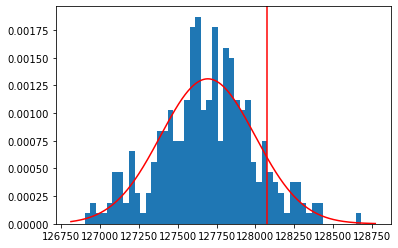

In [110]:
mu, std = stats.norm.fit(hit_distribution)

plt.hist(hit_distribution, bins=50, density=True)
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 1000)
norm_pdf = stats.norm.pdf(x_axis, mu, std)
plt.plot(x_axis, norm_pdf, color="red")
plt.axvline(x=recommended_hit, color="red")
plt.savefig("plots/recom_vs_random.pdf", bbox_inches="tight")
